# NLP Group Project
### Alberto Puentes, Parker Voit, Tyler Applegate
#### Florence Cohort, 2021_08_03

In [35]:
# general imports
import requests
from requests import get
from bs4 import BeautifulSoup
import os
import re
import numpy as np
import pandas as pd
import markdown 
import nltk
import csv

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
from pprint import pprint

# our function modules
import acquire
import prepare
import explore

# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, plot_confusion_matrix

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Project Overview

## Key Findings:
- We found that our [**model**] outperformed all other models, including the baseline. 
- This model achieved [**percent**] overall accuracy on our training data, [**percent**] on our validate set, and finally [**percent**] on the unseen test data set.
- With more time, we would like to explore [**Hawaii, Portugal, and New Zealand**]

## Data Acquisition

In [2]:
# use our function to pull in raw data
repo_df = acquire.get_github_data(cached = True)

In [3]:
acquire.overview(repo_df)

This dataframe has 120 rows and 3 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             120 non-null    object
 1   language         120 non-null    object
 2   readme_contents  119 non-null    object
dtypes: object(3)
memory usage: 3.8+ KB
None
----------------------------------

Unique value counts of each column

repo               120
language             4
readme_contents    119
dtype: int64
----------------------------------

Stats on Numeric Columns

                         repo    language  \
count                     120         120   
unique                    120           4   
top     /rossant/awesome-math  JavaScript   
freq                        1          30   

                                          readme_contents  
count                                        

### Data Acquisition - Key Findings & Takeaways:
- We are looking at 120 observations, evenly distributed across 4 programming languages
- There appears to be 1 null value
- There are also multiple files that are in foreign languages
- For our first iteration, we are going to drop the null value, and foreign language repos

## Data Preparation

In [4]:
# perform our inital data prep and look at key stats
df = prepare.prep_article_data(repo_df, 'readme_contents', tokenizer=prepare.tokenize, extra_words = ['fr','freesvghttpsgithubcomlisadziubaawesomedesigntoolsblobmastermediafreesvg','opensourcesvghttpsgithubcomlisadziubaawesomedesigntoolsblobmastermediaopensourcesvg'])
acquire.overview(df)

This dataframe has 102 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102 entries, 0 to 119
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   repo                        102 non-null    object
 1   language                    102 non-null    object
 2   readme_contents             102 non-null    object
 3   cleaned_readme_contents     102 non-null    object
 4   stemmed_readme_contents     102 non-null    object
 5   lemmatized_readme_contents  102 non-null    object
dtypes: object(6)
memory usage: 5.6+ KB
None
----------------------------------

Unique value counts of each column

repo                          102
language                        4
readme_contents               102
cleaned_readme_contents       102
stemmed_readme_contents       102
lemmatized_readme_contents    102
dtype: int64
----------------------------------


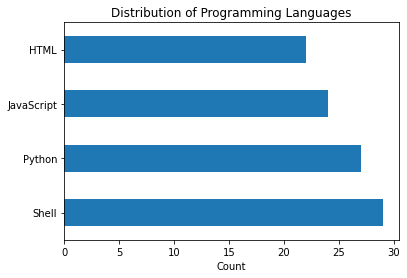

In [5]:
# visualize distribution of target variable

df.language.value_counts().plot.barh()
plt.title('Distribution of Programming Languages')
plt.xlabel("Count")
plt.show()

In [6]:
# split our data prior to exploration, stratifying on target variable 'language'
train, validate, test = prepare.train_validate_test_split(df, 'language')

In [7]:
# what does our training set look like?
acquire.overview(train)

This dataframe has 56 rows and 6 columns.
----------------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 86 to 3
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   repo                        56 non-null     object
 1   language                    56 non-null     object
 2   readme_contents             56 non-null     object
 3   cleaned_readme_contents     56 non-null     object
 4   stemmed_readme_contents     56 non-null     object
 5   lemmatized_readme_contents  56 non-null     object
dtypes: object(6)
memory usage: 3.1+ KB
None
----------------------------------

Unique value counts of each column

repo                          56
language                       4
readme_contents               56
cleaned_readme_contents       56
stemmed_readme_contents       56
lemmatized_readme_contents    56
dtype: int64
----------------------------------

Stats on

### Data Preparation - Key Findings & Takeaways:
- We dropped 1 null observation, and 17 foreign language repos
- We also created new columns of 'cleaned', 'stemmed', and 'lemmatized' data
- Due to dropping the foreign language repos, our distribution is no longer uniform across the 4 programming languages
- Instead of 30 each, we now have:
    - 29 Shell
    - 27 Python
    - 24 JavaScript
    - 22 HTML
- We are hopeful that this imbalance will not impact our modeling too much
- If it does, we will end up having to pull in more data
- Data has been split into train, validate, and test sets that have been stratified on 'language' to keep as much balance as possible to each dataset

## Data Exploration

In [9]:
# create lists of all words, java words, html words, python words, and shell words

all_words = (' '.join(train.cleaned_readme_contents))
java_words = (' '.join(train[train.language == 'JavaScript'].cleaned_readme_contents))
shell_words = (' '.join(train[train.language == 'Shell'].cleaned_readme_contents))
python_words = (' '.join(train[train.language == 'Python'].cleaned_readme_contents))
html_words = (' '.join(train[train.language == 'HTML'].cleaned_readme_contents))

In [10]:
# convert the lists to number counts of each word

all_freq = pd.Series(all_words.split()).value_counts()
java_freq = pd.Series(java_words.split()).value_counts()
shell_freq = pd.Series(shell_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()

In [17]:
# dataframe of word frequencies
freq_df = pd.concat([java_freq, shell_freq, python_freq, html_freq, all_freq], axis=1).fillna(0).astype(int)
freq_df.columns = ['java', 'shell', 'python', 'html', 'all']
freq_df.head()

,java,shell,python,html,all
covid19,280,3,0,1,284
code,256,214,136,64,670
design,225,120,28,48,421
coronavirus,164,0,0,0,164
free,162,203,19,24,408


In [20]:
# let's look at some common words to drop
freq_df.sort_values(by='all', ascending=False)

,java,shell,python,html,all
git,20,514,1118,17,1669
open,71,196,1164,91,1522
install,17,33,1453,10,1513
clone,2,17,1110,3,1132
month,2,9,1073,0,1084
...,...,...,...,...,...
ifconfigpro,0,1,0,0,1
daydreamer,0,1,0,0,1
osing,0,1,0,0,1
oshiat,0,1,0,0,1


In [46]:
parker = freq_df.sort_values(by='all', ascending=False).head(100)

In [49]:
parker[(parker['java']/parker['all'])>.5 |  (parker['shell']/parker['all'])>.5 | (parker['python']/parker['all'])>.5 | (parker['html']/parker['all'])>.5]

TypeError: Cannot perform 'ror_' with a dtyped [float64] array and scalar of type [bool]

In [31]:
freq_df['all'].sort_values(ascending=False).head(30).index

Index(['git', 'open', 'install', 'clone', 'month', 'pip', 'ago', 'years',
       'code', 'web', 'data', 'python', 'mit', 'using', 'source', 'theme',
       'library', '2', '0', 'c', 'tool', '1', 'use', '2017', '3', 'tools',
       'language', 'design', 'free', 'plugin'],
      dtype='object')

In [32]:
add_to_extra_words = list(freq_df['all'].sort_values(ascending=False).head(30).index)

In [45]:

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(train['cleaned_readme_contents'])

pprint(train['cleaned_readme_contents'])
pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names()).argsort(

86     title awesome geek podcasts permalink awesome ...
61     awesome creative coding carefully curated list...
73     ics security tools tips trade developed commun...
112    awesome 5g curated list awesome 5g frameworks ...
43     awesome waf everything web application firewal...
52     awesome wagtail curated list awesome packages ...
53     markdownlintdisable bestof web development pyt...
17     awesome browser extensions github numbers upda...
115    sweden list curated list awesome things use co...
103    macos ios security related tools contents maco...
8      awesome ctf curated list capture flag ctf fram...
38     markdownlintdisable bestof machine learning py...
37     typefaces source code beautification main font...
71     awesome cloud native curated list opensource c...
63     webpack module bundler webpack takes modules d...
85     awesome identity awesome identity singlepage h...
14     lint disable awesomeheading awesomegitrepoage ...
2      awesome design tools awe

AttributeError: 'DataFrame' object has no attribute 'argsort'

In [ ]:
['code',
 'web',
 'data',
 'python',
 'mit',
 'using',
 'source',
 'theme',
 'library',
 '2',
 '0',
 'c',
 'tool',
 '1',
 'use',
 '2017',
 '3',
 'tools',
 'language',
 'design',
 'free',
 'plugin']


In [18]:
this_list = [all_words, java_words, shell_words, python_words, html_words]
that_list = ['all_words', 'java_words', 'shell_words', 'python_words', 'html_words']

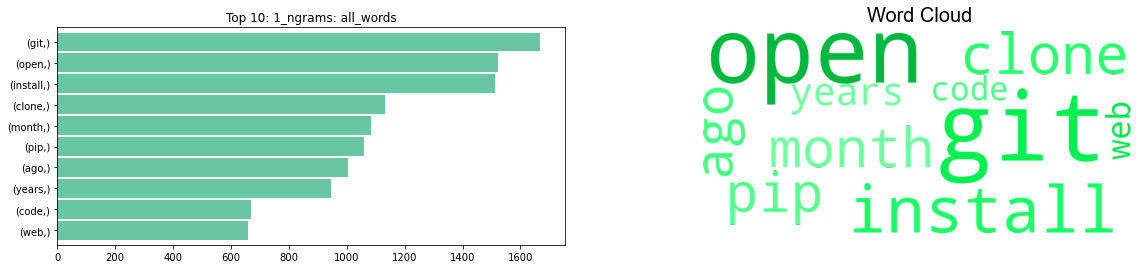

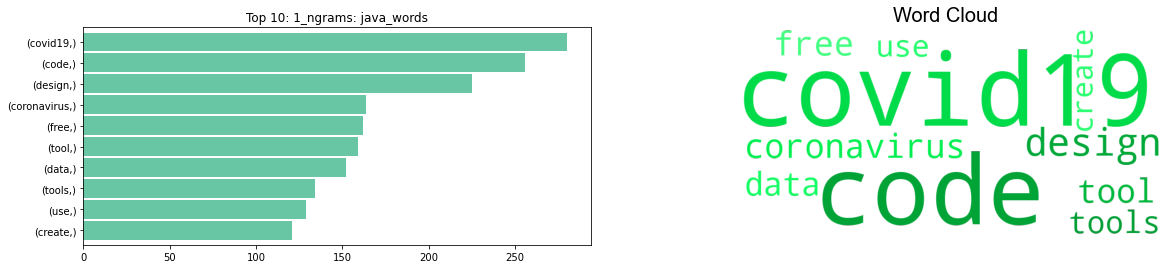

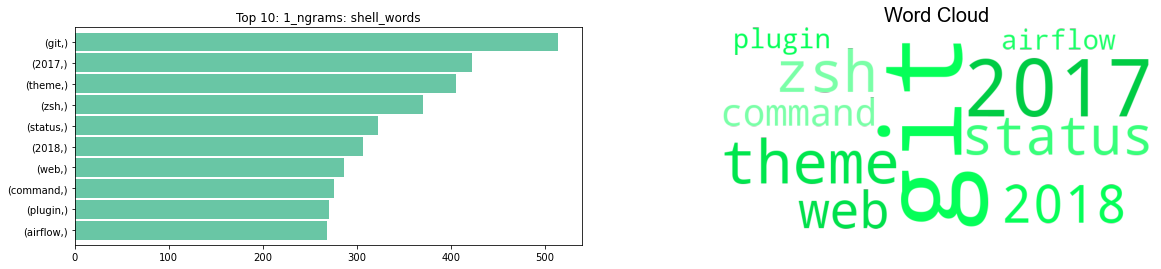

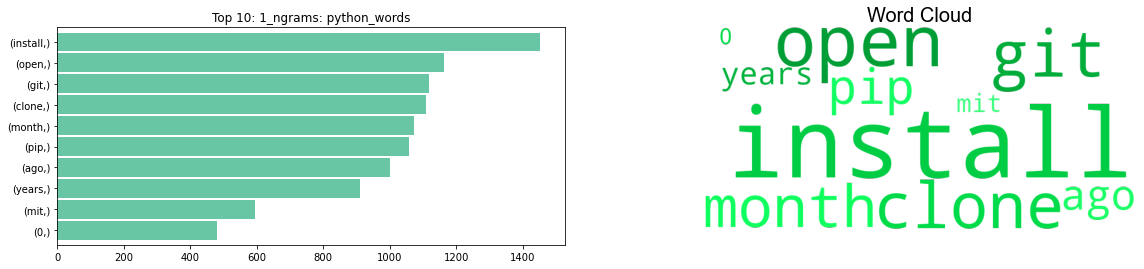

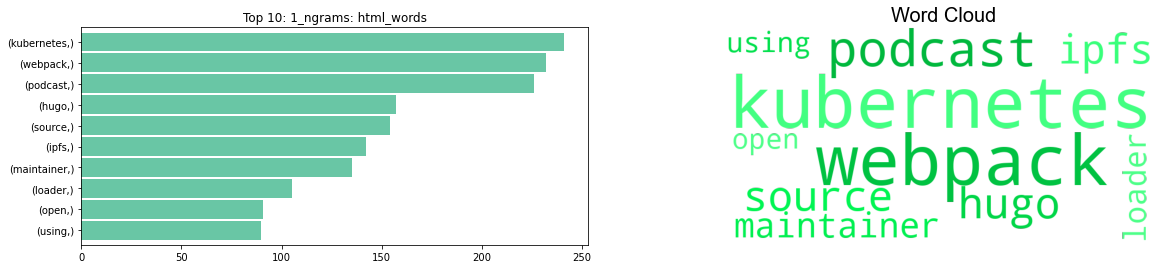

In [19]:
# let's look at the top 10 words for each language
explore.word_count_word_cloud(this_list, that_list)

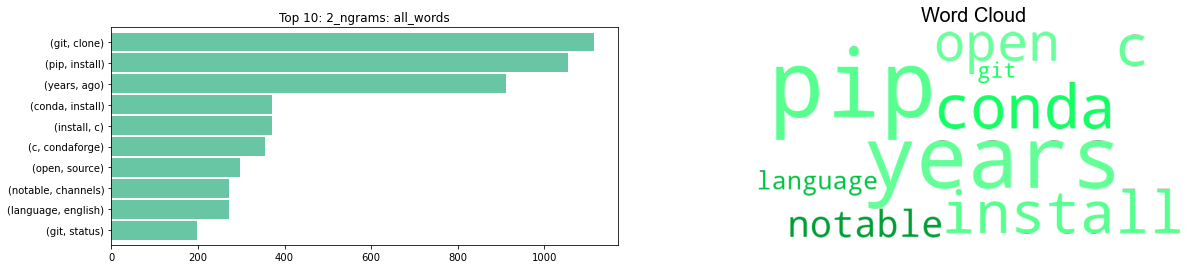

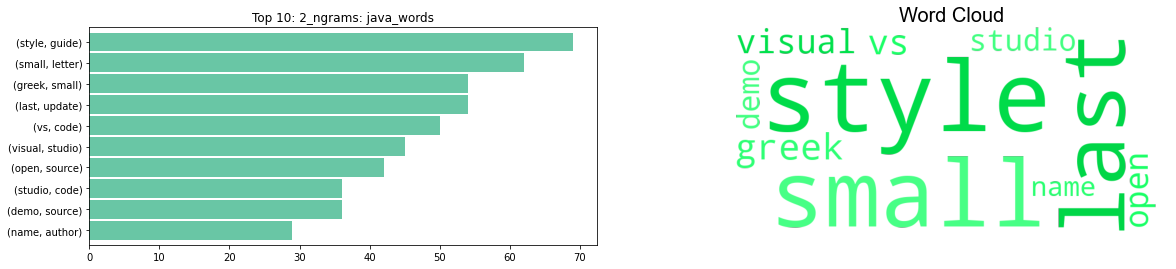

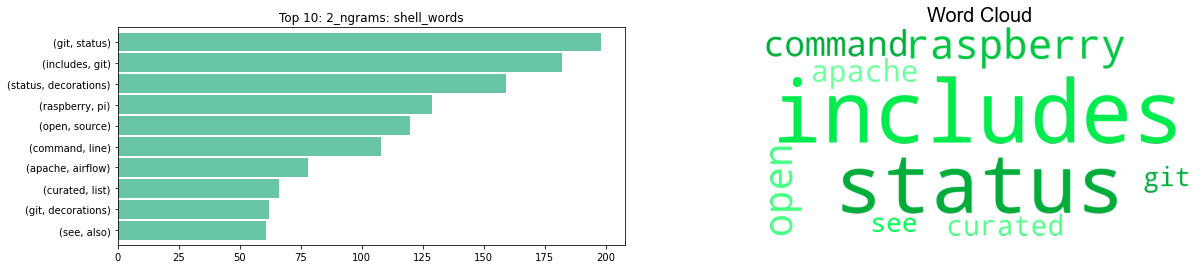

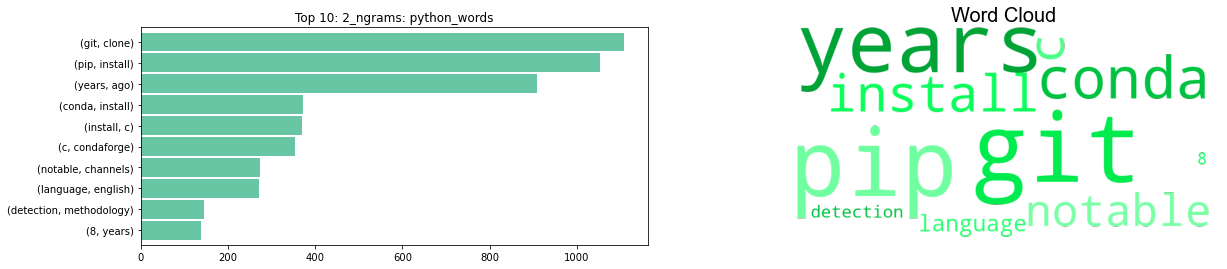

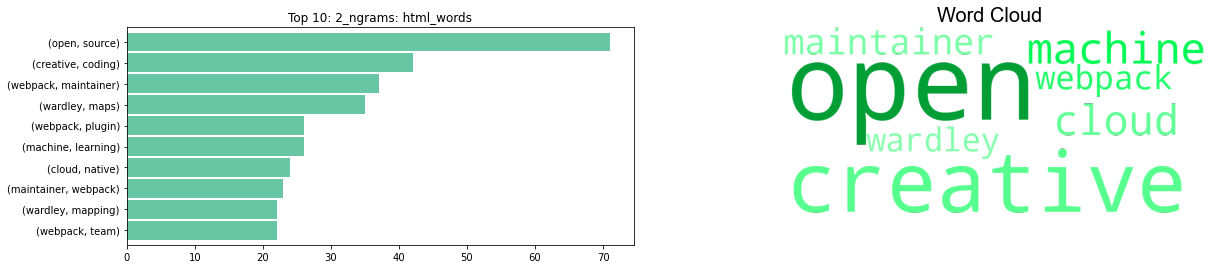

In [14]:
# now let's look at bigrams
explore.word_count_word_cloud(this_list, that_list, n = 2, x=10, title_name = None)

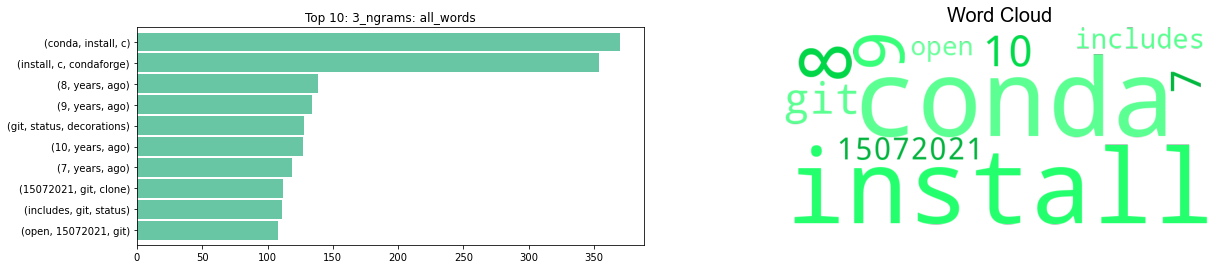

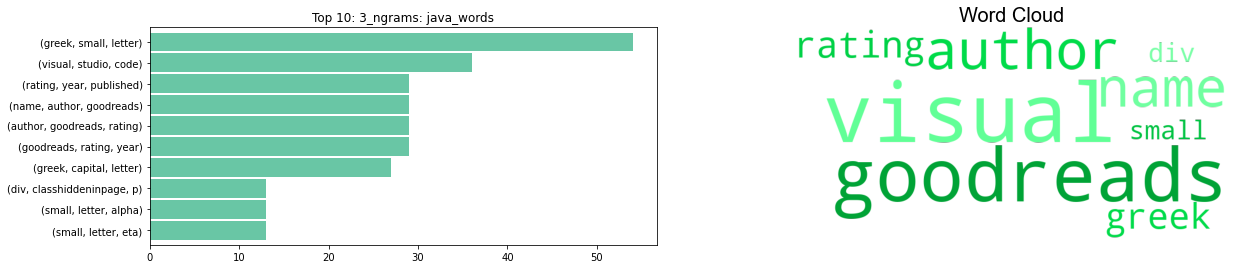

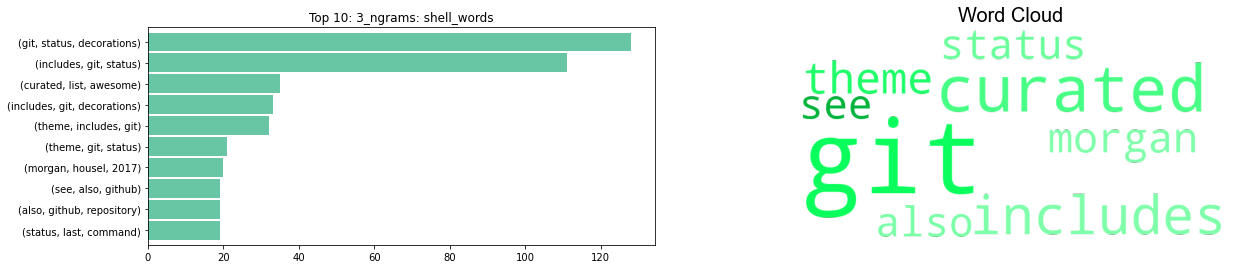

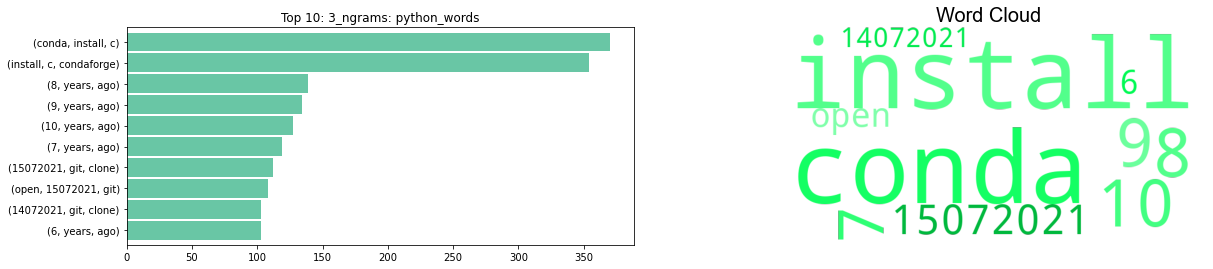

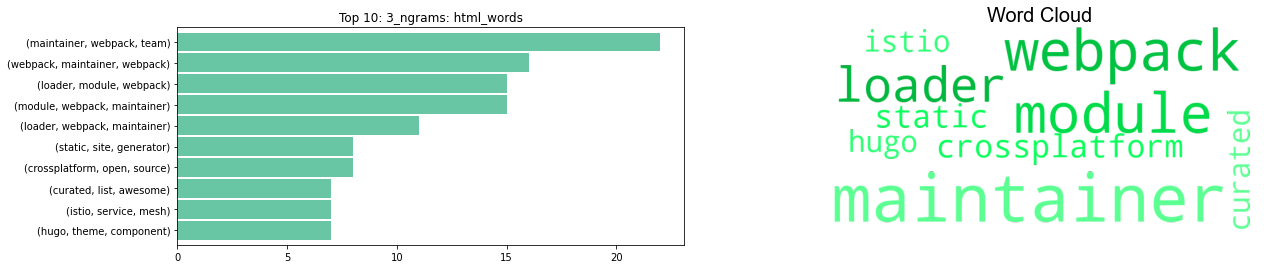

In [15]:
# and finally, let's see trigrams...
explore.word_count_word_cloud(this_list, that_list, n = 3, x=10, title_name = None)

In [16]:
train['length'] = [len(i) for i in train.cleaned_readme_contents]
train.groupby(by = 'language').mean().round(0)

,length
language,
HTML,13579.0
JavaScript,25123.0
Python,42318.0
Shell,36810.0


### Data Exploration - Key Findings & Takeaways:
- Most Common Single Words:
    - Quite a bit of overlap between languages
    - Each language appears to have a few words that are exclusive to their top used list
    - Looks like we need to drop some of the most common words across all languages, to get more value out of single words
- Most Common Bigrams:
    - Less overlap than on single words, but still a little too much
    - We are starting to see a different vocabulary for each programming language emerge
    - Will get more value after dropping most common words across all languages
- Most Common Trigrams:
    - Very interesting to see how many trigrams are made up of overlapping bigrams
    - Least amount of overlap here, and interesting to see how many words appear in multiple trigrams for a language
- Length Takeaways:
    - Python has the largest average character count 
    - JavaScript and Shell have somewhat equal character counts
    - HTML has the least amount

## Model Building

### Model Building - Key Findings & Takeaways:

## Model Evaluation

### Model Evaluation - Key Findings & Takeaways:

## Final Conclusions & Next Steps